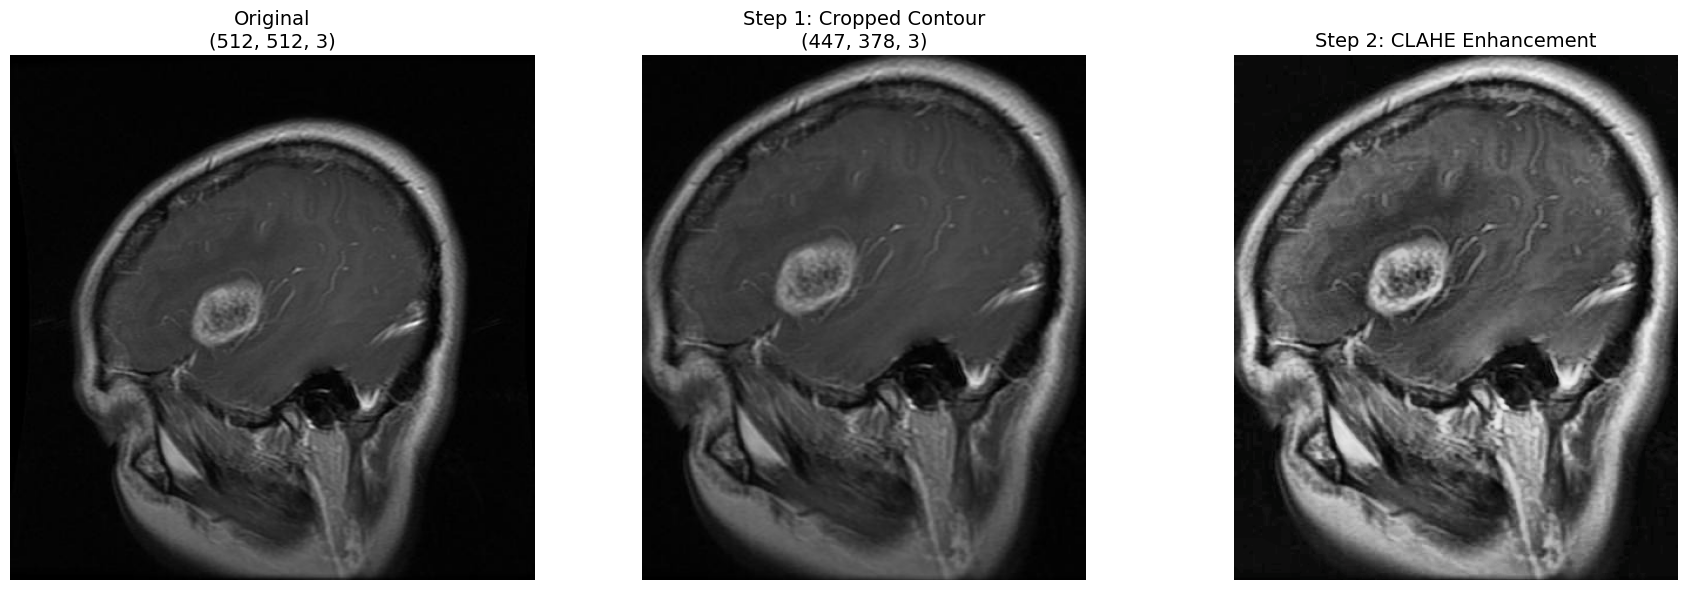

In [1]:
import os
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
from torchvision import models, transforms
from PIL import Image


class ImagePreprocessor:
    @staticmethod
    def crop_brain_contour(image_array):
        # Convert to grayscale and blur slightly to remove noise
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Threshold the image, then perform a series of erosions + dilations
        # to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours in thresholded image, then grab the largest one
        cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not cnts:
            return image_array # Return original if no contour found

        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points (top, bottom, left, right)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Crop the image
        new_image = image_array[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
        return new_image

    @staticmethod
    def apply_clahe(image_array):
        lab = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        return final

def visualize_pipeline(image_path):
    # 1. Load Image (OpenCV loads as BGR, convert to RGB for your class)
    original_bgr = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

    # 2. Run Step 1: Cropping
    cropped_img = ImagePreprocessor.crop_brain_contour(original_rgb)

    # 3. Run Step 2: CLAHE (pass the cropped image into this)
    clahe_img = ImagePreprocessor.apply_clahe(cropped_img)

    # 4. Setup Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot A: Original
    axes[0].imshow(original_rgb)
    axes[0].set_title(f"Original\n{original_rgb.shape}", fontsize=14)
    axes[0].axis('off')

    # Plot B: Cropped (Zoomed in on brain)
    axes[1].imshow(cropped_img)
    axes[1].set_title(f"Step 1: Cropped Contour\n{cropped_img.shape}", fontsize=14)
    axes[1].axis('off')

    # Plot C: CLAHE (Enhanced Contrast)
    axes[2].imshow(clahe_img)
    axes[2].set_title("Step 2: CLAHE Enhancement", fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_pipeline('/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor/gg (103).jpg')

In [2]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []
        self.classes = sorted([
            d for d in os.listdir(root_dir) 
            if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith('.')
        ])        
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Load file paths
        for cls_name in self.classes:
            cls_folder = os.path.join(root_dir, cls_name)
            if os.path.isdir(cls_folder):
                for filename in os.listdir(cls_folder):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.filepaths.append(os.path.join(cls_folder, filename))
                        self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]

        # 1. Read Image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

        # 2. Apply Custom Preprocessing (Crop & Contrast)
        image = ImagePreprocessor.crop_brain_contour(image)
        image = ImagePreprocessor.apply_clahe(image)

        # 3. Convert to PIL for PyTorch Transforms
        image = Image.fromarray(image)

        # 4. Apply PyTorch Transforms (Resize, Tensor conversion, Normalization)
        if self.transform:
            image = self.transform(image)

        return image, label

def get_optimal_device():
    if torch.cuda.is_available():
        print("Device: CUDA (NVIDIA GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        # Check if MPS is built and available
        print("Device: MPS (Mac Metal Acceleration)")
        return torch.device("mps")
    else:
        print("Device: CPU")
        return torch.device("cpu")
    
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N
    
def train(model, train_loader, train_N, optimizer, loss_function, device):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss/len(train_loader), accuracy))

def validate(model, valid_loader, valid_N, loss_function, device):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss/len(valid_loader), accuracy))
    avg_loss = loss/len(valid_loader)
    
    return avg_loss, accuracy

In [3]:
def get_pred(model, weights_path, NUM_CLASSES=4):
    device = get_optimal_device()
    if model == 'densenet121':
        my_model = models.densenet121(weights=None) # No need to download weights, we have our own
        num_ftrs = my_model.classifier.in_features
        my_model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(256, NUM_CLASSES)
        )
    elif model == 'EfficientNet':
        my_model = models.efficientnet_b0(weights=None) # No need to download weights, we have our own
        num_input_features = my_model.classifier[1].in_features 
        my_model.classifier = nn.Sequential(
            nn.Dropout(p=0.3), # EfficientNet standard dropout
            nn.Linear(num_input_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5), # Extra safety against overfitting
            nn.Linear(256, NUM_CLASSES)
        )
        
    elif model == 'vgg16':
        my_model = models.vgg16(weights=None) # No need to download weights, we have our own
        my_model = nn.Sequential(
            my_model.features,       # The convolution layers
            my_model.avgpool,        # The pooling layer
            nn.Flatten(),         # Flatten 7x7x512 -> 25088
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 256), 
            nn.ReLU(),
            nn.Linear(256, NUM_CLASSES) 
        )
    else:
        print('Wrong Input Model Name.')
        return None, None
    try:
        my_model.load_state_dict(torch.load(weights_path, map_location=device))
        my_model = my_model.to(device)
        print(f"Successfully loaded weights from {weights_path}")
    except RuntimeError as e:
        print(f"ERROR: Weight mismatch. Did you change the architecture definition?\n{e}")
        return None, None
        
    my_model.eval()
    y_true = []
    y_pred = []
    
    test_dataset = BrainTumorDataset(root_dir=TEST_DIR, transform=data_transforms_val)
    test_dataloder = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    with torch.no_grad():
        for inputs, labels in test_dataloder:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = my_model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move back to CPU for metric calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    return y_true, y_pred

In [4]:
def get_acc_cm(y_true, y_pred):
    # 1. Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    # 2. Detailed Report (Precision, Recall, F1-Score)
    # Replace target_names with your actual class names (e.g., ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
    class_names = ['Glioma', 'Meningioma', 'No_tumor', 'Pituitary'] 
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # 3. Confusion Matrix Visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [5]:
# Configuration

DATA_DIR = '/kaggle/input/brain-tumor-classification-mri/Training' 
TEST_DIR = '/kaggle/input/brain-tumor-classification-mri/Testing'
NUM_CLASSES = 4
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

device = get_optimal_device()

data_transforms_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

data_transforms_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

Device: CUDA (NVIDIA GPU)


In [6]:
ds_train_A = BrainTumorDataset(root_dir=DATA_DIR, transform=data_transforms_train)
ds_test_A  = BrainTumorDataset(root_dir=TEST_DIR,  transform=data_transforms_train)
full_dataset_aug = ConcatDataset([ds_train_A, ds_test_A])

ds_train_B = BrainTumorDataset(root_dir=DATA_DIR, transform=data_transforms_val)
ds_test_B  = BrainTumorDataset(root_dir=TEST_DIR,  transform=data_transforms_val)
full_dataset_clean = ConcatDataset([ds_train_B, ds_test_B])

labels = []
for i in range(len(ds_train_A)):
    labels.append(ds_train_A[i][1]) 
for i in range(len(ds_test_A)):
    labels.append(ds_test_A[i][1])

train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = 0.2,
    shuffle = True,
    stratify = labels,
    random_state = 42
)

train_dataset = Subset(full_dataset_aug, train_idx)
valid_dataset = Subset(full_dataset_clean, val_idx)
# Assuming BrainTumorDataset is defined elsewhere in your notebook
dataset = BrainTumorDataset(root_dir=DATA_DIR, transform=data_transforms_train)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_N = len(dataloader.dataset)

test_dataloder = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_N = len(test_dataloder.dataset)

print(f"Dataset loaded with {len(dataset)} images.")

Dataset loaded with 2870 images.


## Training

Initializing Densenet121...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 204MB/s]


Starting training on cuda...
--- Phase 1: Training Head ---
Epoch : 0
Train - Loss: 1.2926 Accuracy: 0.3784
Valid - Loss: 1.2374 Accuracy: 0.3461
Validation Accuracy improved (0.0000 --> 0.3461). Saving model...
Epoch : 1
Train - Loss: 1.1190 Accuracy: 0.5745
Valid - Loss: 1.0504 Accuracy: 0.6386
Validation Accuracy improved (0.3461 --> 0.6386). Saving model...
Epoch : 2
Train - Loss: 0.9791 Accuracy: 0.6526
Valid - Loss: 0.9251 Accuracy: 0.7075
Validation Accuracy improved (0.6386 --> 0.7075). Saving model...
Epoch : 3
Train - Loss: 0.8775 Accuracy: 0.6982
Valid - Loss: 0.8383 Accuracy: 0.7519
Validation Accuracy improved (0.7075 --> 0.7519). Saving model...
Epoch : 4
Train - Loss: 0.8032 Accuracy: 0.7193
Valid - Loss: 0.7725 Accuracy: 0.7642
Validation Accuracy improved (0.7519 --> 0.7642). Saving model...
Epoch : 5
Train - Loss: 0.7568 Accuracy: 0.7388
Valid - Loss: 0.7347 Accuracy: 0.7642
Validation Accuracy improved (0.7642 --> 0.7642). Saving model...
Epoch : 6
Train - Loss: 0.71

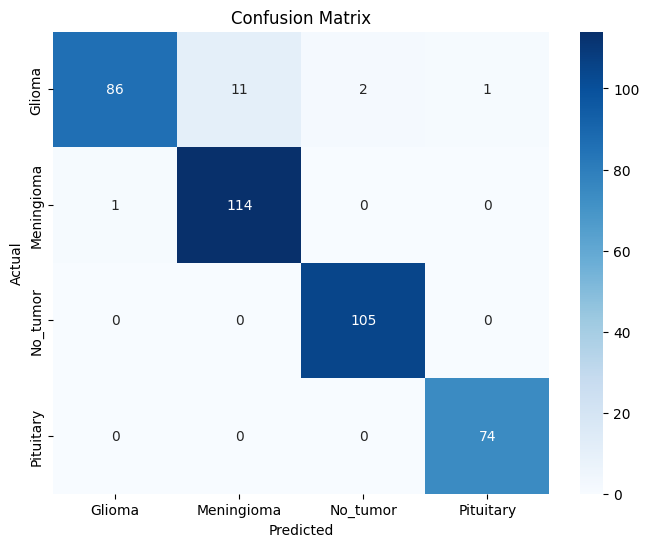

In [7]:
# Densenet121
def main():
    print("Initializing Densenet121...")
    my_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    for param in my_model.parameters():
        param.requires_grad = False
    
    num_ftrs = my_model.classifier.in_features
    my_model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5), 
        nn.Linear(256, NUM_CLASSES)
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()), lr=LEARNING_RATE, weight_decay=1e-4)
    my_model = my_model.to(device)
    best_model_wts = copy.deepcopy(my_model.state_dict())
    best_acc = 0.0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    
    print(f"Starting training on {device}...")
    
    # 7. PHASE 1: Train Only the Head (Frozen Backbone)
    num_epochs = 10
    print("--- Phase 1: Training Head ---")
    for epoch in range(num_epochs):
        print('Epoch : {}'.format(epoch))
        train(my_model, dataloader, train_N, optimizer, criterion, device)
        val_loss, val_acc = validate(my_model, test_dataloder, test_N, criterion, device)
        scheduler.step(val_loss)
    
        if val_acc > best_acc:
            print(f'Validation Accuracy improved ({best_acc:.4f} --> {val_acc:.4f}). Saving model...')
            best_acc = val_acc
            best_model_wts = copy.deepcopy(my_model.state_dict())
    
    print(f"\nPhase 1 Complete. Loading best model with Accuracy: {best_acc:.4f}")
    my_model.load_state_dict(best_model_wts)
    
    # 8. PHASE 2: Fine Tuning (Unfreeze Backbone)
    print("--- Phase 2: Fine Tuning Whole Model ---")
    
    # Unfreeze all parameters
    for param in my_model.parameters():
        param.requires_grad = True
        
    # Lower the learning rate significantly for fine-tuning
    optimizer = optim.Adam(my_model.parameters(), lr=5e-4, weight_decay=1e-4) 
    
    fine_tune_epochs = 10  # Usually need fewer epochs here
    for epoch in range(fine_tune_epochs):
        print('Fine Tune Epoch: {}'.format(epoch))
        train(my_model, dataloader, train_N, optimizer, criterion, device)
        val_loss, val_acc = validate(my_model, test_dataloder, test_N, criterion, device)
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            print(f'Validation Accuracy improved ({best_acc:.4f} --> {val_acc:.4f}). Saving model...')
            best_acc = val_acc
            best_model_wts = copy.deepcopy(my_model.state_dict())
            
        if val_acc < (best_acc - 0.10):
            print("Accuracy dropping significantly. Stopping early.")
            break
    
    torch.save(my_model.state_dict(), './best_brain_densenet121.pth')
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    
    y_true, y_pred = get_pred('densenet121','./best_brain_densenet121.pth')
    get_acc_cm(y_true, y_pred)

if __name__ == "__main__":
    main()

Initializing VGG16...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 248MB/s]


Starting training on cuda...
--- Phase 1: Training Head ---
Epoch : 0
Train - Loss: 0.7098 Accuracy: 0.7036
Valid - Loss: 0.5003 Accuracy: 0.8116
Validation Accuracy improved (0.0000 --> 0.8116). Saving model...
Epoch : 1
Train - Loss: 0.3951 Accuracy: 0.8525
Valid - Loss: 0.3961 Accuracy: 0.8668
Validation Accuracy improved (0.8116 --> 0.8668). Saving model...
Epoch : 2
Train - Loss: 0.3109 Accuracy: 0.8778
Valid - Loss: 0.3455 Accuracy: 0.8775
Validation Accuracy improved (0.8668 --> 0.8775). Saving model...
Epoch : 3
Train - Loss: 0.2492 Accuracy: 0.9062
Valid - Loss: 0.3745 Accuracy: 0.8729
Epoch : 4
Train - Loss: 0.2483 Accuracy: 0.9123
Valid - Loss: 0.3756 Accuracy: 0.8668
Epoch : 5
Train - Loss: 0.1927 Accuracy: 0.9303
Valid - Loss: 0.3193 Accuracy: 0.8928
Validation Accuracy improved (0.8775 --> 0.8928). Saving model...
Epoch : 6
Train - Loss: 0.1592 Accuracy: 0.9422
Valid - Loss: 0.3507 Accuracy: 0.9035
Validation Accuracy improved (0.8928 --> 0.9035). Saving model...
Epoch : 

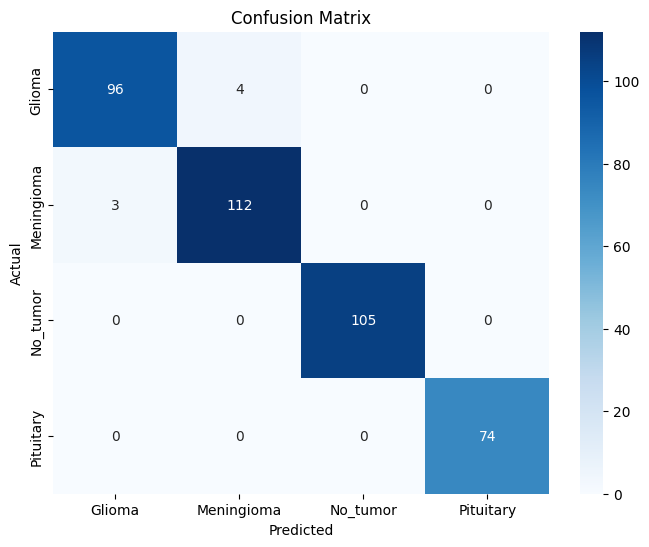

In [8]:
# VGG16
def main():
    print("Initializing VGG16...")
    my_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in my_model.parameters():
        param.requires_grad = False
    
    my_model = nn.Sequential(
        my_model.features,       # The convolution layers
        my_model.avgpool,        # The pooling layer
        nn.Flatten(),         # Flatten 7x7x512 -> 25088
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 256), 
        nn.ReLU(),
        nn.Linear(256, NUM_CLASSES) 
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()), lr=LEARNING_RATE, weight_decay=1e-4)
    my_model = my_model.to(device)
    best_model_wts = copy.deepcopy(my_model.state_dict())
    best_acc = 0.0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    
    print(f"Starting training on {device}...")
    
    # PHASE 1: Train Only the Head (Frozen Backbone)
    num_epochs = 10
    print("--- Phase 1: Training Head ---")
    for epoch in range(num_epochs):
        print('Epoch : {}'.format(epoch))
        train(my_model, dataloader, train_N, optimizer, criterion, device)
        val_loss, val_acc = validate(my_model, test_dataloder, test_N, criterion, device)
        scheduler.step(val_loss)
    
        if val_acc > best_acc:
            print(f'Validation Accuracy improved ({best_acc:.4f} --> {val_acc:.4f}). Saving model...')
            best_acc = val_acc
            best_model_wts = copy.deepcopy(my_model.state_dict())
    
    print(f"\nPhase 1 Complete. Loading best model with Accuracy: {best_acc:.4f}")
    my_model.load_state_dict(best_model_wts)
    
    # PHASE 2: Fine Tuning (Unfreeze Backbone)
    print("--- Phase 2: Fine Tuning Whole Model ---")
    for param in my_model.parameters():
        param.requires_grad = True
        
    optimizer = optim.Adam(my_model.parameters(), lr=3e-5, weight_decay=1e-4) 
    
    fine_tune_epochs = 10  # Usually need fewer epochs here
    for epoch in range(fine_tune_epochs):
        print('Fine Tune Epoch: {}'.format(epoch))
        train(my_model, dataloader, train_N, optimizer, criterion, device)
        val_loss, val_acc = validate(my_model, test_dataloder, test_N, criterion, device)
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            print(f'Validation Accuracy improved ({best_acc:.4f} --> {val_acc:.4f}). Saving model...')
            best_acc = val_acc
            best_model_wts = copy.deepcopy(my_model.state_dict())
            
        if val_acc < (best_acc - 0.10):
            print("Accuracy dropping significantly. Stopping early.")
            break
    
    torch.save(my_model.state_dict(), './best_brain_tumor_vgg16.pth')
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    y_true, y_pred = get_pred('vgg16', './best_brain_tumor_vgg16.pth')
    get_acc_cm(y_true, y_pred)

if __name__ == "__main__":
    main()

Initializing EfficientNet...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 227MB/s]


Starting training on cuda...
--- Phase 1: Training Head ---
Epoch : 0
Train - Loss: 1.2785 Accuracy: 0.4638
Valid - Loss: 1.1996 Accuracy: 0.5620
Validation Accuracy improved (0.0000 --> 0.5620). Saving model...
Epoch : 1
Train - Loss: 1.0801 Accuracy: 0.6335
Valid - Loss: 0.9511 Accuracy: 0.7305
Validation Accuracy improved (0.5620 --> 0.7305). Saving model...
Epoch : 2
Train - Loss: 0.9076 Accuracy: 0.7120
Valid - Loss: 0.7962 Accuracy: 0.7580
Validation Accuracy improved (0.7305 --> 0.7580). Saving model...
Epoch : 3
Train - Loss: 0.7904 Accuracy: 0.7327
Valid - Loss: 0.7124 Accuracy: 0.7596
Validation Accuracy improved (0.7580 --> 0.7596). Saving model...
Epoch : 4
Train - Loss: 0.7317 Accuracy: 0.7380
Valid - Loss: 0.6543 Accuracy: 0.7749
Validation Accuracy improved (0.7596 --> 0.7749). Saving model...
Epoch : 5
Train - Loss: 0.6876 Accuracy: 0.7587
Valid - Loss: 0.6275 Accuracy: 0.7795
Validation Accuracy improved (0.7749 --> 0.7795). Saving model...
Epoch : 6
Train - Loss: 0.66

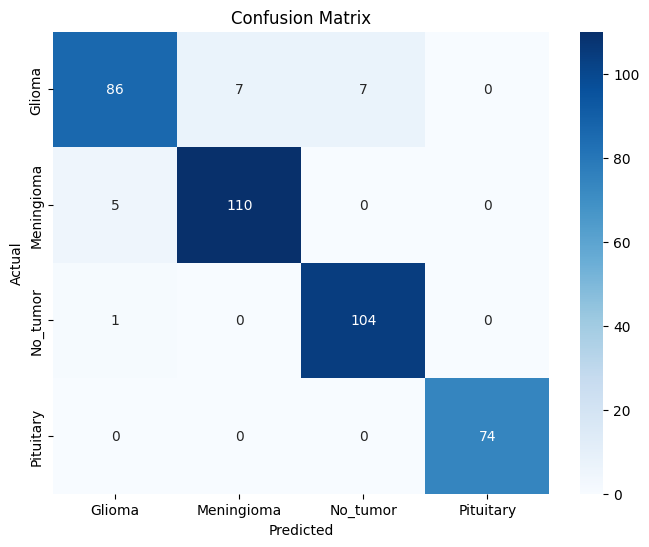

In [9]:
# Efficientnet_b0
def main():    
    print("Initializing EfficientNet...")
    my_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    for param in my_model.parameters():
        param.requires_grad = False
    num_input_features = my_model.classifier[1].in_features 
    my_model.classifier = nn.Sequential(
        nn.Dropout(p=0.3), # EfficientNet standard dropout
        nn.Linear(num_input_features, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5), # Extra safety against overfitting
        nn.Linear(256, NUM_CLASSES)
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()), lr=LEARNING_RATE, weight_decay=1e-4)
    my_model = my_model.to(device)
    best_model_wts = copy.deepcopy(my_model.state_dict())
    best_acc = 0.0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    
    print(f"Starting training on {device}...")
    
    # PHASE 1: Train Only the Head (Frozen Backbone)
    num_epochs = 10
    print("--- Phase 1: Training Head ---")
    for epoch in range(num_epochs):
        print('Epoch : {}'.format(epoch))
        train(my_model, dataloader, train_N, optimizer, criterion, device)
        val_loss, val_acc = validate(my_model, test_dataloder, test_N, criterion, device)
        scheduler.step(val_loss)
    
        if val_acc > best_acc:
            print(f'Validation Accuracy improved ({best_acc:.4f} --> {val_acc:.4f}). Saving model...')
            best_acc = val_acc
            best_model_wts = copy.deepcopy(my_model.state_dict())
    
    print(f"\nPhase 1 Complete. Loading best model with Accuracy: {best_acc:.4f}")
    my_model.load_state_dict(best_model_wts)
    
    # PHASE 2: Fine Tuning (Unfreeze Backbone)
    print("--- Phase 2: Fine Tuning Whole Model ---")
    for param in my_model.features[-1].parameters():
        param.requires_grad = True
        
    optimizer = optim.Adam(my_model.parameters(), lr=5e-4, weight_decay=1e-4) 
    
    fine_tune_epochs = 15
    for epoch in range(fine_tune_epochs):
        print('Fine Tune Epoch: {}'.format(epoch))
        train(my_model, dataloader, train_N, optimizer, criterion, device)
        val_loss, val_acc = validate(my_model, test_dataloder, test_N, criterion, device)
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            print(f'Validation Accuracy improved ({best_acc:.4f} --> {val_acc:.4f}). Saving model...')
            best_acc = val_acc
            best_model_wts = copy.deepcopy(my_model.state_dict())
            
        if val_acc < (best_acc - 0.10):
            print("Accuracy dropping significantly. Stopping early.")
            break
    
    torch.save(my_model.state_dict(), './best_brain_tumor_EfficientNet.pth')
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    y_true, y_pred = get_pred('EfficientNet', './best_brain_tumor_EfficientNet.pth')
    get_acc_cm(y_true, y_pred)

if __name__ == "__main__":
    main()

## Validation

In [10]:
ds_val_train = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transforms_val)
ds_val_test  = BrainTumorDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Testing',  transform=data_transforms_val)
full_dataset_aug = ConcatDataset([ds_val_train, ds_val_test])

test_dataloder = DataLoader(full_dataset_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

def get_pred_for_external_data(model, weights_path, NUM_CLASSES=4):
    device = get_optimal_device()
    if model == 'densenet121':
        my_model = models.densenet121(weights=None) # No need to download weights, we have our own
        num_ftrs = my_model.classifier.in_features
        my_model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(256, NUM_CLASSES)
        )
    elif model == 'EfficientNet':
        my_model = models.efficientnet_b0(weights=None) # No need to download weights, we have our own
        num_input_features = my_model.classifier[1].in_features 
        my_model.classifier = nn.Sequential(
            nn.Dropout(p=0.3), # EfficientNet standard dropout
            nn.Linear(num_input_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5), # Extra safety against overfitting
            nn.Linear(256, NUM_CLASSES)
        )
        
    elif model == 'vgg16':
        my_model = models.vgg16(weights=None) # No need to download weights, we have our own
        my_model = nn.Sequential(
            my_model.features,       # The convolution layers
            my_model.avgpool,        # The pooling layer
            nn.Flatten(),         # Flatten 7x7x512 -> 25088
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 256), 
            nn.ReLU(),
            nn.Linear(256, NUM_CLASSES) 
        )
    else:
        print('Wrong Input Model Name.')
        return None, None
    try:
        my_model.load_state_dict(torch.load(weights_path, map_location=device))
        my_model = my_model.to(device)
        print(f"Successfully loaded weights from {weights_path}")
    except RuntimeError as e:
        print(f"ERROR: Weight mismatch. Did you change the architecture definition?\n{e}")
        return None, None
        
    my_model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloder:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = my_model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move back to CPU for metric calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    return y_true, y_pred

Device: CUDA (NVIDIA GPU)
Successfully loaded weights from ./best_brain_densenet121.pth
Test Accuracy: 94.67%

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.97      0.96      0.97      1621
  Meningioma       0.97      0.92      0.94      1645
    No_tumor       0.99      0.91      0.95      2000
   Pituitary       0.87      1.00      0.93      1757

    accuracy                           0.95      7023
   macro avg       0.95      0.95      0.95      7023
weighted avg       0.95      0.95      0.95      7023



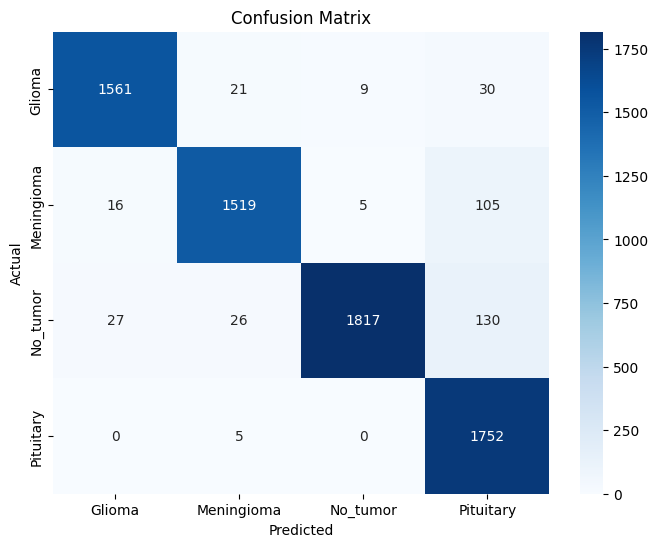

In [11]:
#Use External Data to validate the accuracy of Densenet121
y_true, y_pred = get_pred_for_external_data('densenet121', './best_brain_densenet121.pth')
get_acc_cm(y_true, y_pred)

Device: CUDA (NVIDIA GPU)
Successfully loaded weights from ./best_brain_tumor_vgg16.pth
Test Accuracy: 96.34%

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.94      0.96      0.95      1621
  Meningioma       0.92      0.98      0.95      1645
    No_tumor       1.00      0.94      0.97      2000
   Pituitary       0.99      0.98      0.99      1757

    accuracy                           0.96      7023
   macro avg       0.96      0.96      0.96      7023
weighted avg       0.96      0.96      0.96      7023



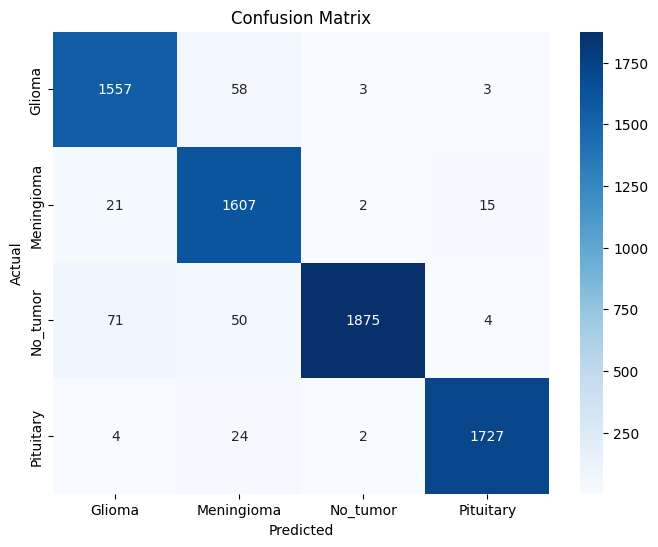

In [12]:
#Use External Data to validate the accuracy of VGG16
y_true, y_pred = get_pred_for_external_data('vgg16', './best_brain_tumor_vgg16.pth')
get_acc_cm(y_true, y_pred)

Device: CUDA (NVIDIA GPU)
Successfully loaded weights from ./best_brain_tumor_EfficientNet.pth
Test Accuracy: 94.69%

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.94      0.93      0.94      1621
  Meningioma       0.88      0.95      0.91      1645
    No_tumor       0.99      0.93      0.96      2000
   Pituitary       0.97      0.98      0.98      1757

    accuracy                           0.95      7023
   macro avg       0.95      0.95      0.95      7023
weighted avg       0.95      0.95      0.95      7023



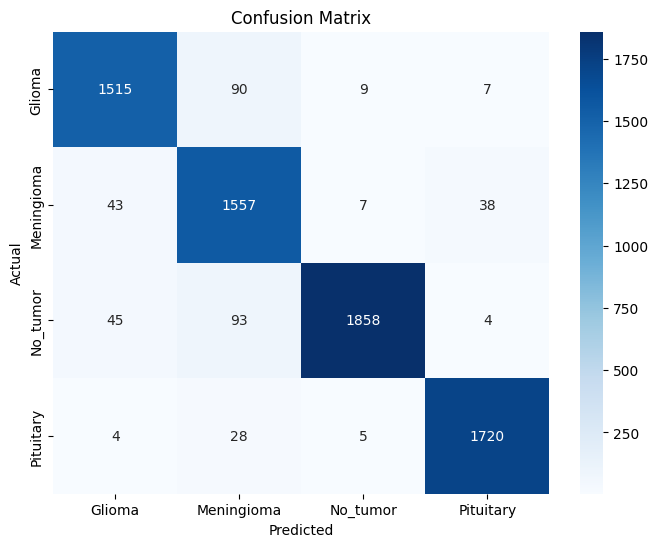

In [13]:
#Use External Data to validate the accuracy of EfficientNet
y_true, y_pred = get_pred_for_external_data('EfficientNet', './best_brain_tumor_EfficientNet.pth')
get_acc_cm(y_true, y_pred)